In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rdm
from scipy import integrate, signal, optimize
from matplotlib import gridspec
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

Defining Coupled ODEs

In [2]:
# defining regulatory functions and their derivatives

f = lambda a: 1 / (1 + (a/a_n)**2) # regulatory function for k_n
f_prime = lambda a: -2*a/a_n**2 / (1 + (a/a_n)**2)**2 # derivative of f w.r.t. a

g = lambda a: (a/a_t)**2 / (1 + (a/a_t)**2) # regulatory function for k_t
g_prime = lambda a: 2*a/a_t**2 / (1 + (a/a_t)**2)**2 # derivative of g w.r.t. a

# f_R, the fraction of total cell synthesis capacity devoted to ribosome production
f_R = lambda a: (-f_prime(a)*g(a)*phiR_max + f(a)*g_prime(a)*phiR_min) / (-f_prime(a)*g(a) + f(a)*g_prime(a))

# f_X, fraction of cell synthesis capacity devoted to division protein production
f_X = lambda a: alpha*(phiR_max - f_R(a)) + beta

In [3]:
# defining growth rate function

def kappa(a, phi_R):

    k_t = k_t0 * g(a)

    k = k_t * (phi_R - phiR_min) - mu_ns
    return k

In [4]:
# ribosome mass fraction ODE (f_R variable)

def dphiR_dt(phi_R, t, a):

    k_t = k_t0 * g(a) # translational efficiency

    dpdt = k_t * (phi_R - phiR_min) * (f_R(a) - phi_R)
    return dpdt

In [5]:
def dXdt(X, t, a, phi_R, V):

    dxdt = f_X(a) * (kappa(a, phi_R) + mu_ns) * V - mu_x * X
    return dxdt

In [6]:
# amino acid concentration ODE (variable nutrient conc.(c))

def dAAdt(a, t, phi_R):

    k_n = k_n0(t) * f(a) # nutritional efficiency, depends on concentration of nutrients outside cell
    k_t = k_t0 * g(a) # translational efficiency

    dadt = k_n * (phiR_max - phi_R) - k_t * (phi_R - phiR_min) + mu_ns
    return dadt

In [7]:
def dVdt(V, t, a, phi_R):

    dvdt = kappa(a, phi_R) * V
    return dvdt

In [8]:
# packing coupled ODEs together to be solved by odeint

def odes(Species, t):

    phi_R,X,a,V = Species # Tuple unpakcing of each species, equivalent to phi_R = Species[0] // a = Species[1]

    phiR_ode = dphiR_dt(phi_R, t, a)
    X_ode = dXdt(X, t, a, phi_R, V)
    a_ode = dAAdt(a, t, phi_R)
    V_ode = dVdt(V, t, a, phi_R)

    dSpeciesdt = [phiR_ode,X_ode,a_ode,V_ode]
    return dSpeciesdt

Defining functions to calculate steady state initial conditions

In [9]:
# function for phi_R at steady state

def phiR_ss(a):
    
    k_n = k_n0(0) * f(a) # nutritional efficiency, depends on concentration of nutrients outside cell
    k_t = k_t0 * g(a) # translational efficiency

    return (k_n*phiR_max + k_t*phiR_min + mu_ns) / (k_n + k_t)

In [10]:
# function for calculating steady state conditions for given parameters

def func(x):
    return [phiR_ss(x[0]) - x[1], # x[0]=a, x[1]=phi_R
            f_R(x[0]) - x[1]]

Parameters

In [14]:
# parameters

phiR_min = 0.049 # Scott et al. 2010
phiR_max = 0.55 # Scott et al. 2010

a_n = 1e-3 # level to trigger negative feeback inhibition of amino acid supply, Scott et al. 2014
a_t = 1e-4 # amino acid level for efficient peptide elongation, Scott et al. 2014

X0_mean = 1 # mean amount of division proteins required for cell to divide
X0_stdDev = 0.05 # standard deviation of X0_mean

k_t0 = 2.6
kn0_high = 60
kn0_low = 0

alpha = 4.5
beta = 1.1
mu_x = 2.5
mu_ns = 0.1

#### Simulating single cell trajectory

Simulation and Plot Functions

In [12]:
# simulation implementation

def SimulateAndPlot(simulation_max, iterations):

    phi_R = np.zeros((iterations,1))
    phi_R[0] = phi_R0

    a = np.zeros((iterations,1))
    a[0] = a0

    X = np.zeros((iterations,1))
    X[0] = f_X(a0) * V0 * (kappa(a0, phi_R0) + mu_ns) / mu_x

    V = np.zeros((iterations,1))
    V[0] = V0

    t = np.linspace(0,simulation_max,iterations)

    i=1 # start at i=1 so a[i-1]=a0 and phi_R[i-1]=phi_R0
    while i < iterations:

        species_0 = [phi_R[i-1,0], X[i-1,0], a[i-1,0], V[i-1,0]] # packing initial conditions

        species = integrate.odeint(odes, species_0, t[i-1:i+1]) # solving for values at next timestep

        phi_R[i], X[i], a[i], V[i] = species[1,:] # unpacking and storing species values for new time step

        X_0 = np.random.normal(X0_mean, X0_stdDev) # drawing random value for amount of division proteins required to trigger division, taken from normal distribution
        # if cell has added threshold volume amount, it will then divide
        if X[i-1] >= X_0:
            r = np.random.normal(0.5, 0.04) # drawing random value for volume allocation to daughter cell, taken from normal distribution
            V[i] = r * V[i-1] # cell volume is divided roughly in half
            X[i] = 0 # division protein concentration is equally distributed between daughter cells

        i +=1

    PlotGrowth(phi_R, X, a, V, t)

### Figure 5A

In [ ]:
# plot function

def PlotGrowth(phi_R, X, a, V, Time):

    # Plot Layout
    plt.rc('font', size=18) #controls default text size
    fig, ax1 = plt.subplots(4,1, figsize=(10,12))
    # set height ratios for subplots
    gs = gridspec.GridSpec(4,1, height_ratios=[0.75,1,1,1.5])

    # Plot 1
    ax0 = plt.subplot(gs[0])
    ax0.plot(Time, k_n0(Time), color='g')
    ax0.set_yticks([]) # removing tickmarks and labels
    ax0.set_yticklabels([])
    ax0.set_ylabel('Nutrient Conc., $c$', color='g')
    ax0.annotate('$\u03C4_{pulse}=1/{feed rate}$', xy=(0.5,36))
    # plotting arrow
    ax0.annotate("",
            xy=(0.38, 30), xycoords='data',
            xytext=(1.12, 30), textcoords='data',
            arrowprops=dict(arrowstyle="<->",
                            connectionstyle="arc3"),
            )

    # Plot 2
    fR = f_R(a)
    ax1 = plt.subplot(gs[1], sharex=ax0)
    ax1.plot(Time, fR, color='k', linestyle='--')
    ax1.set_ylabel('$f_R$', color='k')
    ax1.tick_params(axis='y', labelcolor='k')
    ax1.set_ylim(min(fR)-0.02, max(fR)+0.02)
    # Adding twin axes
    ax2 = ax1.twinx()
    ax2.plot(Time, phi_R, color='indianred')
    ax2.set_ylabel('$\phi_R$', color='indianred')
    ax2.tick_params(axis='y', labelcolor='indianred')

    # Plot 3
    ax3 = plt.subplot(gs[2], sharex=ax1)
    ax3.plot(Time, f_X(a)*(kappa(a, phi_R)+mu_ns), color='mediumblue')
    ax3.set_ylabel('$k_P$ $(h^{-1}\mu m^{-3})$', color='mediumblue')
    ax3.tick_params(axis='y', labelcolor='mediumblue')

    # Plot 4
    ax7 = plt.subplot(gs[3])
    ax7.set_ylabel('Cell Volume ($\mu m^3$)')
    ax7.plot(Time, V, color='k')
    ax7.set_xlabel('Time (h)')
    # Adding twin axes
    ax8 = ax7.twinx()
    ax8.plot(Time, X, color='mediumblue', linestyle='--')
    ax8.set_ylabel('Division Protein, $\\tilde{X}$', color='mediumblue')
    ax8.tick_params(axis='y', labelcolor='mediumblue')

    plt.subplots_adjust(hspace=.0)

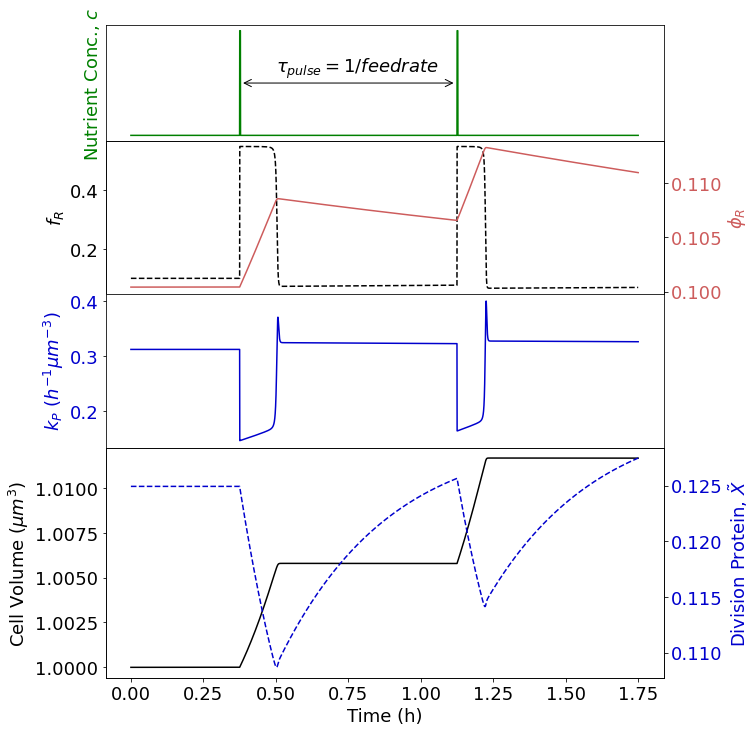

In [ ]:
simulation_max = 1.75 # in hrs
iterations = 10000 #number of simulation points

# concentration function
period = 0.75 # time at which nutrient shift occurs, in hrs
pulse_frac = 10/(period * 3600)
k_n0 = lambda t: (kn0_high - kn0_low) * (signal.square(2*np.pi*t/period + np.pi, duty=pulse_frac)/2 + 0.5) + kn0_low

# solving for initial conditions to produce steady state
root = optimize.fsolve(func, [1e-5, 0.4]) # requires guess of initial conditions
phi_R0 = root[1] # initial proteome fraction
a0 = root[0] # initial amin acid concentration
V0 = 1 # initial cell volume, in um^3

SimulateAndPlot(simulation_max, iterations)

### Figure 5B

In [ ]:
# plot function

def PlotGrowth(phi_R, X, a, V, Time):

    # Plot Layout
    plt.rc('font', size=18) #controls default text size
    fig, ax = plt.subplots(1,1, figsize=(10,5))
    ax.annotate('Feed Rate$=40$ h$^{-1}$', xy=(-0.18,5.5))
    # plotting arrow
    ax.annotate('$T_{lag}$', xy=(2.5,2.65))
    ax.annotate("",
            xy=(0, 2.5), xycoords='data',
            xytext=(4.6, 2.5), textcoords='data',
            arrowprops=dict(arrowstyle="<->",
                            connectionstyle="arc3"),
            )

    ax.plot(Time, V, color='k')
    ax.set_ylabel('Cell Volume ($\mu m^3$)')
    ax.set_xlabel('Time (h)')
    ax.set_ylim(2,5.8)
    # Adding twin axes
    ax1 = ax.twinx()
    ax1.set_ylabel('Division Protein, $\\tilde{X}$', color='mediumblue')
    ax1.plot(Time, X, color='mediumblue')
    ax1.tick_params(axis='y', labelcolor='mediumblue')

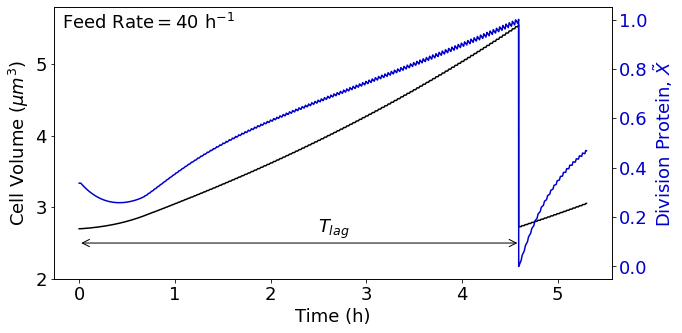

In [ ]:
X0_stdDev = 0

simulation_max = 5.3 # in hrs
iterations = 10000 #number of simulation points

# concentration function
period = 2/60 # time at which nutrient shift occurs, in hrs
pulse_frac = 10/(period * 3600)
k_n0 = lambda t: (kn0_high - kn0_low) * (signal.square(2*np.pi*t/period + np.pi, duty=pulse_frac)/2 + 0.5) + kn0_low

# solving for initial conditions to produce steady state
root = optimize.fsolve(func, [1e-5, 0.2]) # requires guess of initial conditions
phi_R0 = root[1] # initial proteome fraction
a0 = root[0] # initial amin acid concentration
V0 = 2.7 # initial cell volume, in um^3

SimulateAndPlot(simulation_max, iterations)

#### Simulating time to first division

In [18]:
# simulation implementation

def lagTime(simulation_max, iterations):

    phi_R = np.zeros((iterations,1))
    phi_R[0] = phi_R0

    a = np.zeros((iterations,1))
    a[0] = a0

    X = np.zeros((iterations,1))
    X[0] = f_X(a0) * V0 * (kappa(a0, phi_R0) + mu_ns) / mu_x

    V = np.zeros((iterations,1))
    V[0] = V0

    t = np.linspace(0,simulation_max,iterations)

    i=1 # start at i=1 so a[i-1]=a0 and phi_R[i-1]=phi_R0
    while i < iterations:

        species_0 = [phi_R[i-1,0], X[i-1,0], a[i-1,0], V[i-1,0]] # packing initial conditions

        species = integrate.odeint(odes, species_0, t[i-1:i+1]) # solving for values at next timestep

        phi_R[i], X[i], a[i], V[i] = species[1,:] # unpacking and storing species values for new time step

        X_0 = 1
        # if cell has added threshold volume amount, it will then divide
        if X[i-1] >= X_0:
            return t[i]

        i +=1

### Figure 5C

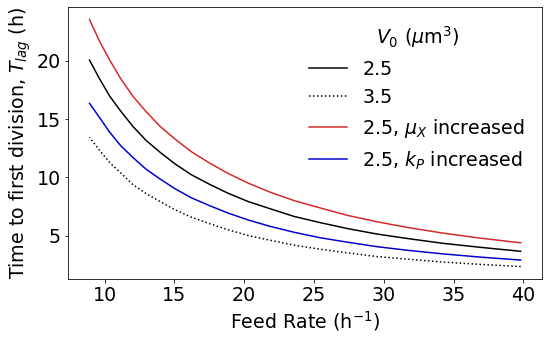

In [ ]:
prd = np.logspace(-1.6,-0.95,21)
v0 = [2.5,3.5]

simulation_max = 60 # in hrs
iterations = 30000 #number of simulation points

X0_stdDev = 0
period = 1
k_n0 = lambda t: (kn0_high - kn0_low) * (signal.square(2*np.pi*t/period + np.pi, duty=10/(period * 3600))/2 + 0.5) + kn0_low

# solving for initial conditions to produce steady state
root = optimize.fsolve(func, [1e-5, 0.2]) # requires guess of initial conditions
phi_R0 = root[1] # initial proteome fraction
a0 = root[0] # initial amin acid concentration

fig = plt.figure(figsize=(8.5,5))
plt.rc('font', size=19) #controls default text size
style = ['-',':']
n = 0
for x in v0:
    V0 = x
    div_t = np.zeros((len(prd),1))
    i = 0
    for y in prd:
        period = y
        div_t[i] = lagTime(simulation_max, iterations)
        i+=1
    plt.plot(1/prd, div_t, label=x, color='k', linestyle=style[n])
    n+=1

# Simulate with increased degradation rate
mu_x = 3
V0 = v0[0]
divT_mu = np.zeros((len(prd),1))
i = 0
for y in prd:
    period = y
    divT_mu[i] = lagTime(simulation_max, iterations)
    i+=1
plt.plot(1/prd, divT_mu, label='2.5, $\mu_X$ increased', color='tab:red')

# Simulate with increased division protein production rate
alpha = 4.5*1.2
beta = 1.1*1.2
mu_x = 2.5
divT_kP = np.zeros((len(prd),1))
i = 0
for y in prd:
    period = y
    divT_kP[i] = lagTime(simulation_max, iterations)
    i+=1
plt.plot(1/prd, divT_kP, label='2.5, $k_P$ increased', color='mediumblue')

plt.xlabel('Feed Rate (h$^{-1}$)')
# plt.xscale('log')
plt.ylabel('Time to first division, $T_{lag}$ (h)')
plt.legend(title='$V_0$ ($\mu$m$^3$)', frameon=False)
plt.show()

#### Simulating exit from stationary phase

In [ ]:
# simulation implementation

def SimulateAndPlot(simulation_max, iterations, replicates):

    t = np.linspace(simulation_min,simulation_max,iterations)

    V = np.zeros((iterations,replicates))
    V_0 = np.zeros((iterations,replicates)) # birth volume
    delta_V = np.zeros((iterations,replicates))
    tau = np.zeros((iterations,replicates))

    m=0
    while m < replicates:
        V[0,m] = rdm.randint(40,120)/100 # assigning random initial cell volume, in um^3
        V_0[0,m] = V[0,m]

        phi_R = np.zeros((iterations,1))
        phi_R[0] = phi_R0

        a = np.zeros((iterations,1))
        a[0] = a0

        X = np.zeros((iterations,1))
        X[0] = f_X(a0) * V_0[0,m] * (kappa(a0, phi_R0) + mu_ns) / mu_x

        V_divide = V_0[0,m]
        t_divide = simulation_min
        i=1 # start at i=1 so a[i-1]=a0 and phi_R[i-1]=phi_R0
        while i < iterations:

            species_0 = [phi_R[i-1,0], X[i-1,0], a[i-1,0], V[i-1,m]] # packing initial conditions

            species = integrate.odeint(odes, species_0, t[i-1:i+1]) # solving for values at next timestep

            phi_R[i], X[i], a[i], V[i,m] = species[1,:] # unpacking and storing species values for new time step

            X_0 = np.random.normal(X0_mean, X0_stdDev) # drawing random value for amount of division proteins required to trigger division, taken from normal distribution
            # if cell has added threshold volume amount, it will then divide
            if X[i-1] >= X_0:

                delta_V[i,m] = V[i-1,m] - V_divide
                tau[i,m] = t[i-1] - t_divide

                r = np.random.normal(0.5, 0.04) # drawing random value for volume allocation to daughter cell, taken from normal distribution
                V_divide = r * V[i-1,m] # cell volume is divided roughly in half
                t_divide = t[i]
                V[i,m] = V_0[i,m] = V_divide
                X[i] = 0 # division protein concentration is reset to zero

            i +=1
        m +=1

    PlotGrowth(V, t)
    return V, V_0, t, delta_V, tau

In [ ]:
# plot function

def PlotGrowth(V, Time):

    # Plot Layout
    fig = plt.figure(figsize=(8.5,5))
    plt.rc('font', size=17) #controls default text size
    plt.axvline(t_shift, linestyle='--', color='k')
    plt.annotate('Nutrient Upshift', xy=(t_shift-0.4,1.5), size=17, rotation=90)

    plt.plot(Time, V[:,0:-1], alpha=0.3) # plotting all but one trajectory transparent
    plt.plot(Time, V[:,-1], color='k')
    plt.xlabel('Time (h)')
    plt.ylabel('Cell Volume ($\mu m^3$)')

#### Figure 5D

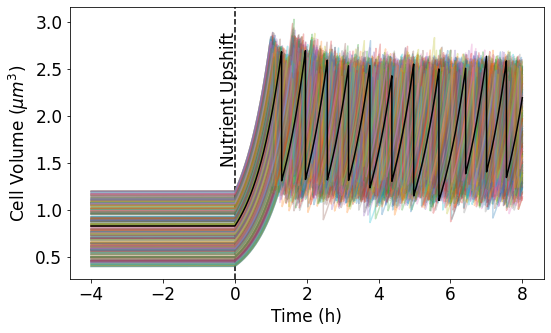

In [ ]:
X0_stdDev = 0.05

simulation_min = -4
simulation_max = 8 # in hrs
iterations = 10000 # number of simulation points per replicate
replicates = 400 # number of replicate simulations

# concentration function
t_shift = 0 # time at which nutrient shift occurs, in hrs
k_n0 = lambda t: (kn0_high - kn0_low) * np.heaviside(t-t_shift,0.5) + kn0_low

# solving for initial conditions to produce steady state
root = optimize.fsolve(func, [1e-5, 0.2]) # requires guess of initial conditions
phi_R0 = root[1] # initial proteome fraction
a0 = root[0] # initial amin acid concentration

V, V_0, t, delta_V, tau = SimulateAndPlot(simulation_max, iterations, replicates)

#### Sizer Analysis

Cleaning data to visualize $\Delta V$, $V_0$, and $\tau$

In [48]:
# creating dataframes for time, tau, deltaV, and V_0
df_tau = pd.DataFrame(tau, columns=range(replicates)) # not currently using
df_deltaV = pd.DataFrame(delta_V, columns=range(replicates))
df_V0 = pd.DataFrame(V_0, columns=range(replicates))

$\Delta V$

In [49]:
# removing zeros from deltaV data and appending into one column
deltaV_clean = pd.DataFrame(columns=['delta V'])
for x in range(replicates):

    delta_cut = df_deltaV.loc[(df_deltaV[x] > 0), [x]] # removing zeros
    delta_cut = delta_cut.rename(columns={x:'delta V'}).reset_index(drop=True) # renaming column so data can be appended to existing 'delta V' column
    delta_cut = delta_cut.loc[0] # only keep first row becuase only interested in first division
    deltaV_clean = deltaV_clean.append(delta_cut).reset_index(drop=True) # appending and reindexing

$V_0$

In [50]:
# removing zeros from tau data and appending into one column
V0_clean = pd.DataFrame(columns=['V_0'])
for x in range(replicates):

    V0_cut = df_V0.loc[(df_V0[x] > 0), [x]] # removing zeros
    V0_cut = V0_cut.rename(columns={x:'V_0'}).reset_index(drop=True) # renaming column so data can be appended to existing 'tau' column
    V0_cut = V0_cut.loc[0] # only keep first row becuase only interested in first division
    V0_clean = V0_clean.append(V0_cut).reset_index(drop=True) # appending and reindexing

#### Figure 5E

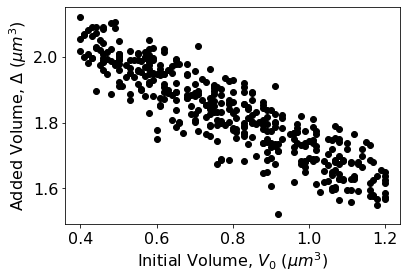

In [ ]:
# joining deltaV and V0 dfs
V_V0 = pd.concat([deltaV_clean,V0_clean], axis=1, join='inner')
V_V0 = V_V0.loc[(V_V0['delta V'] > 0.01)] # removing cells which divided before upshift

# plotting
fig = plt.figure()
plt.rc('font', size=16) #controls default text size

plt.scatter(V_V0['V_0'], V_V0['delta V'], color='k')
plt.xlabel('Initial Volume, $V_0$ ($\mu m^3$)')
plt.ylabel('Added Volume, $\Delta$ ($\mu m^3$)')
plt.show()

In [ ]:
# correlation coefficient
cor = np.corrcoef(V_V0['V_0'], V_V0['delta V'])[0,1]
params = np.polyfit(V_V0['V_0'], V_V0['delta V']+V_V0['V_0'],1)
print(cor)

-0.8951331288003088
